In [863]:
#Objective : To predict the housing prices in Australia using advanced regression

In [864]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE


In [865]:
#import dataset
data=pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [866]:
#Data Inspection
data.shape

(1460, 81)

1460 records with 81 columns present in data

In [867]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [868]:
# data[['MSSubClass','YearBuilt','YearRemodAdd','GarageYrBlt']]=data[['MSSubClass','YearBuilt','YearRemodAdd','GarageYrBlt']].astype('object')
data[['MSSubClass']]=data[['MSSubClass']].astype('object')

In [869]:
data.dtypes.value_counts()

object     44
int64      34
float64     3
dtype: int64

43 text features and 38 numeric features

In [870]:
#Missing value ratio
#Removing columns having more than 75% missing values in entries
perc=data.isna().sum()/len(data)
cols_to_del = [col for col,val in perc.items() if val>0.75]
print("Columns removed",cols_to_del)

Columns removed ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [871]:
#Remove ID column since it has unique values and not useful for prediction
cols_to_del.append("Id")
data.drop(columns=cols_to_del,inplace=True)
data.shape

(1460, 76)

In [872]:
dup_rows=data.duplicated().sum()
print("Duplicate records present in data are:",dup_rows)

Duplicate records present in data are: 0


In [873]:
#Removing columns with low variation in data
#Check categorical data
data_cat=data.select_dtypes(include=['object'])
cat_cols=list(data_cat.columns)
# print(len(cat_cols))
#Identify columns which have more than 90% of same category value
data_cols_var=[]
for cat in cat_cols:
    val_cnt=pd.DataFrame(data_cat[cat].value_counts(normalize=True))
    if float(val_cnt.max())>=0.9:
        data_cols_var.append(cat)
del_len=len(data_cols_var)
print(f"{del_len} Categorical Columns with more than 90% of single category : {data_cols_var}")

13 Categorical Columns with more than 90% of single category : ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive']


In [874]:
#Remove low variation columns since they are not useful for prediction
data.drop(columns=data_cols_var,inplace=True)
data.shape

(1460, 63)

<AxesSubplot:xlabel='SalePrice'>

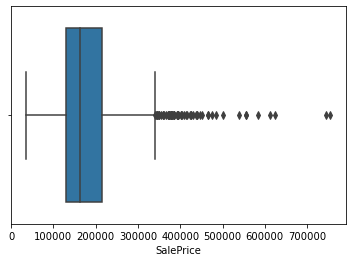

In [875]:
#Removing outliers - Target Variable
sns.boxplot(data["SalePrice"])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

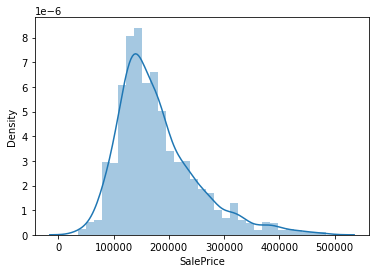

In [876]:
#We observe some outliers in the target Variable, we remove the extreme points above 500000 price
data=data[data["SalePrice"]<500000]
#Observing Distribution of sale price
sns.distplot(data["SalePrice"])

In [877]:
#Impute Missing Values
missing=data.isna().sum()
cols_missing_data = [col for col,val in missing.items() if val>0]
cat_missing_cols=list(data[cols_missing_data].select_dtypes(include=['object']).columns)
num_missing_cols=list(data[cols_missing_data].select_dtypes(include=['int64','float64']).columns)

In [878]:
#Impute using mode for categorical and median for numeric variables
for col in list(data.columns):
    if col in cat_missing_cols:
        mod=data[col].mode()
        data[col].fillna(mod,inplace=True)
    if col in num_missing_cols:
        med=data[col].median()
        data[col].fillna(med,inplace=True)

In [879]:
print(data.shape)

(1451, 63)


There are still 63 features, and its important to select the relevant features correlating with the target variable

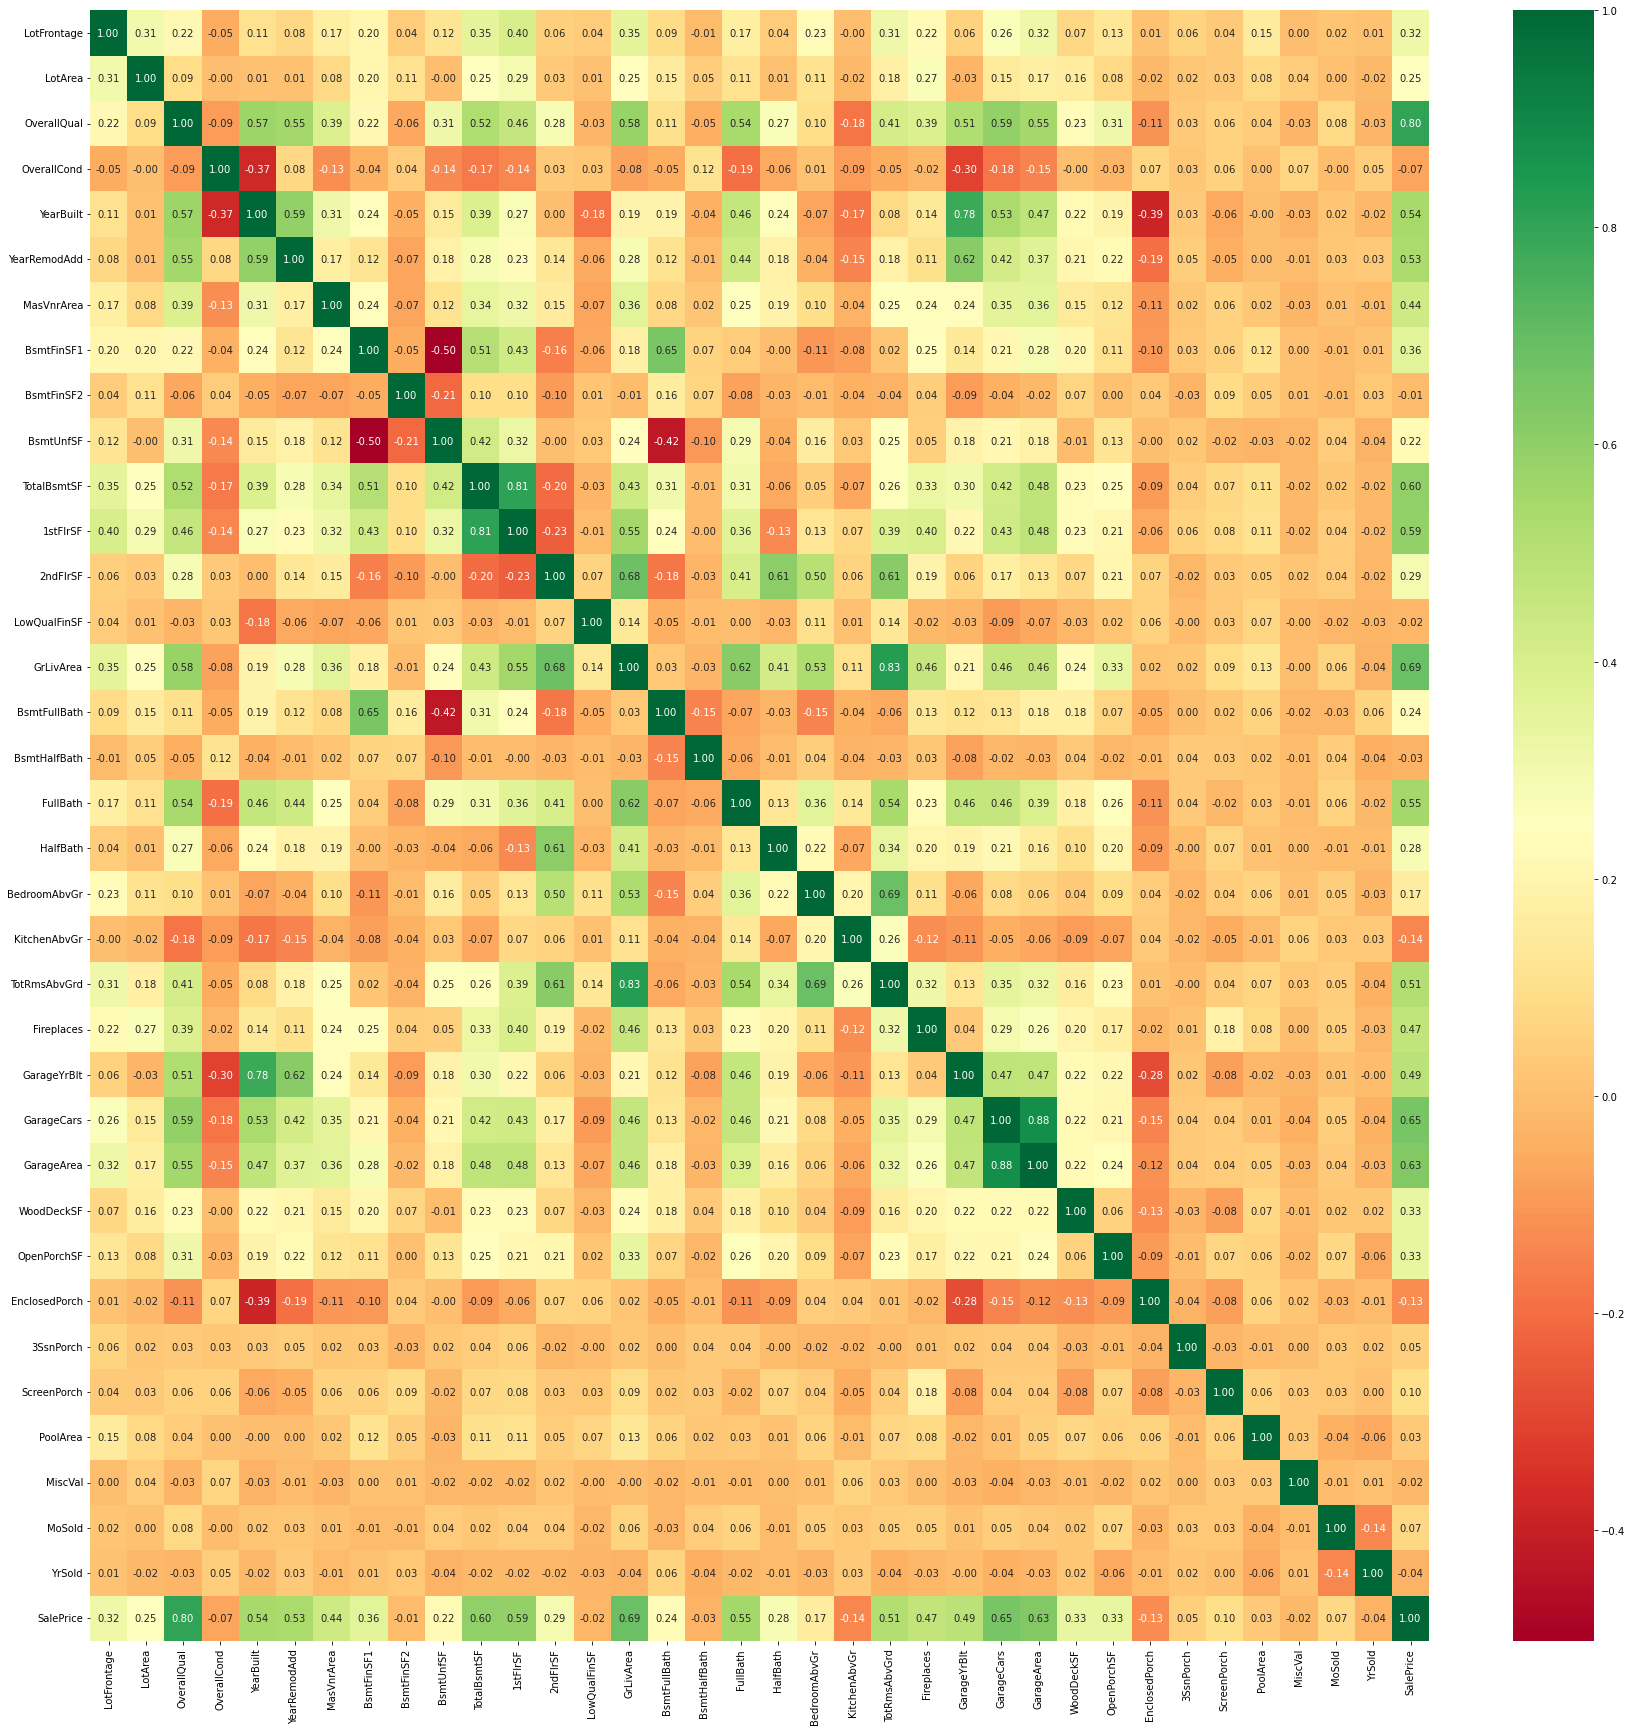

In [880]:
#Checking correlation of numeric variables with target variable
num_cols=list(data.select_dtypes(include=['int64','float64']).columns)
plt.figure(figsize=(30,30))
corr_mat=data[num_cols].corr()
sns.heatmap(corr_mat,cmap="RdYlGn",annot=True,fmt='.2f')
plt.show()

In [881]:
#Removing highly correlated features( corr >= 0.8) - Based on data dictionary understanding
#Correlated Features --> Feature kept in model
# 1. YrBuilt & GarageYrBlt --> YrBuilt
# 2. TotalBsmntSF & 1stFlrSF --> TotalBsmntSF
# 3. TotRmsAbvGrd & GrLivArea --> GrLivArea
# 4. GarageCars & GarageArea --> GarageCars
corr_num_vars=["GarageYrBlt","1stFlrSF","TotRmsAbvGrd","GarageArea"]
#Remove from Data
data.drop(columns=corr_num_vars,inplace=True)
#Top correlating numeric features with Target Variable for EDA along with sale price
num_top=["OverallQual","GrLivArea","GarageCars","FullBath","TotalBsmtSF","SalePrice"]

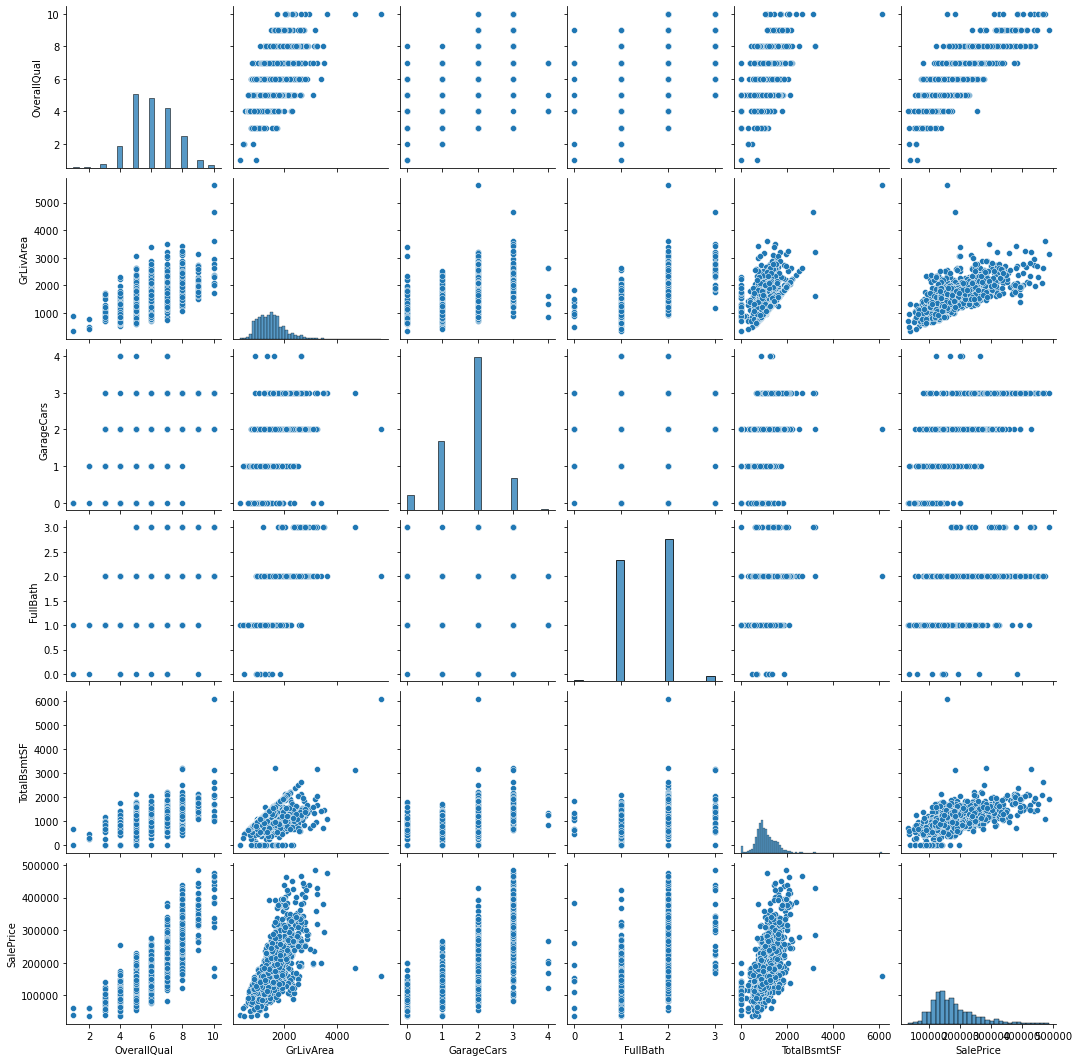

In [882]:
data[num_top]
sns.pairplot(data[num_top])

The numeric features showed a linear correlation with the sale price(target variable), we can use the linear regression framework

Total numeric features 32


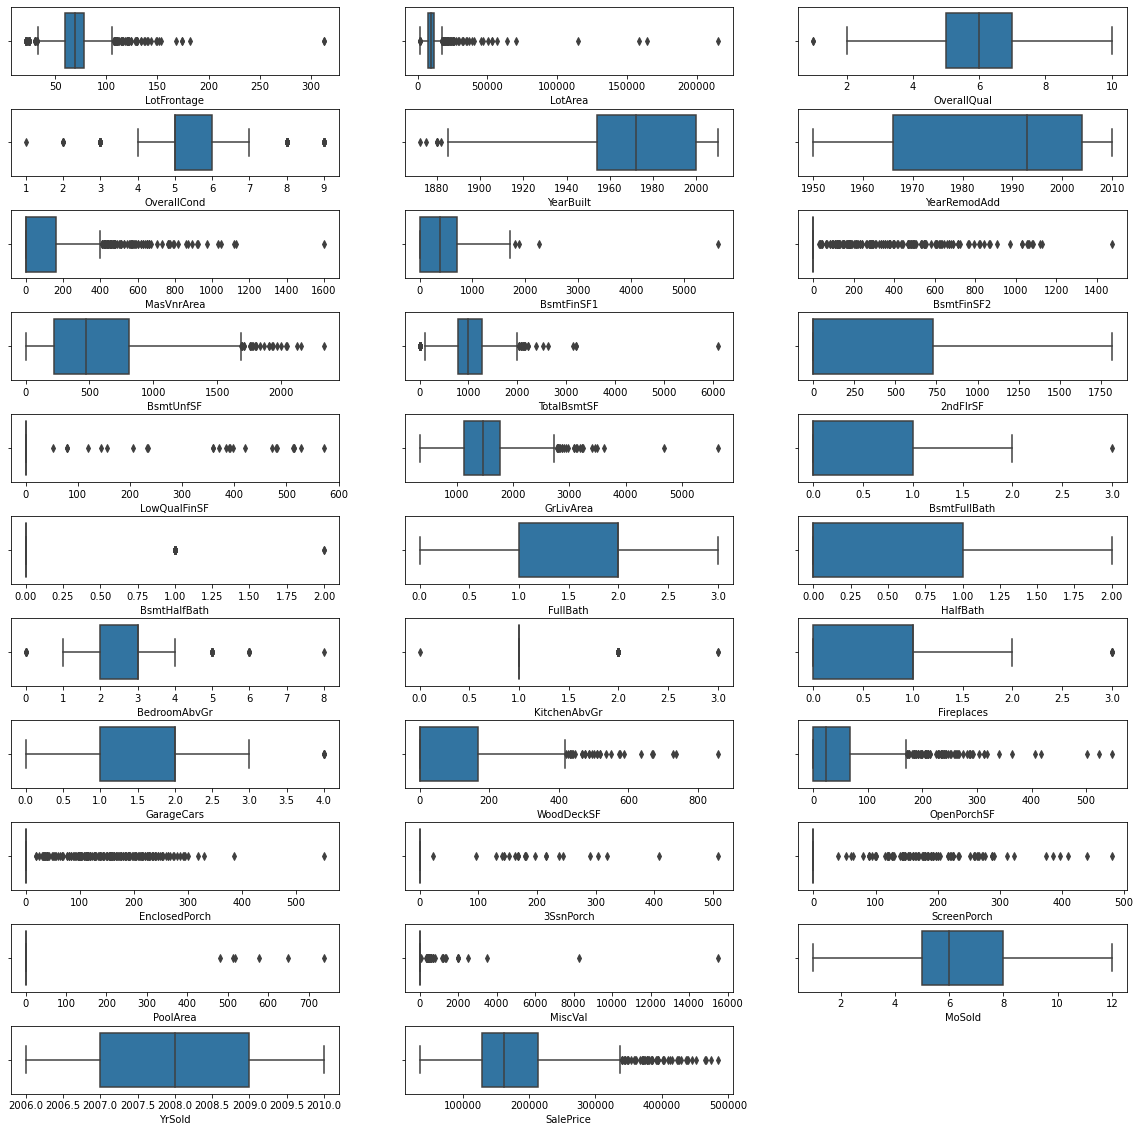

In [883]:
for corrnum in corr_num_vars:
    num_cols.remove(corrnum)
print("Total numeric features",len(num_cols))
tickers = num_cols
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Data Distribution", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(11, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.boxplot(data=data,x=ticker)
    ax.set_ylabel("")
plt.show()


In [884]:
#Removing columns with improper distribution in box plots(lots of outliers and no Iqr)
impr_dist_cols=["BsmtHalfBath","MiscVal","PoolArea","KitchenAbvGr","BsmtHalfBath"]
data.drop(columns=impr_dist_cols,inplace=True)
num_cols=list(set(num_cols)-set(impr_dist_cols))        

In [885]:
cat_cols=list(data.select_dtypes(include=['object']).columns)
print(cat_cols)

['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition']


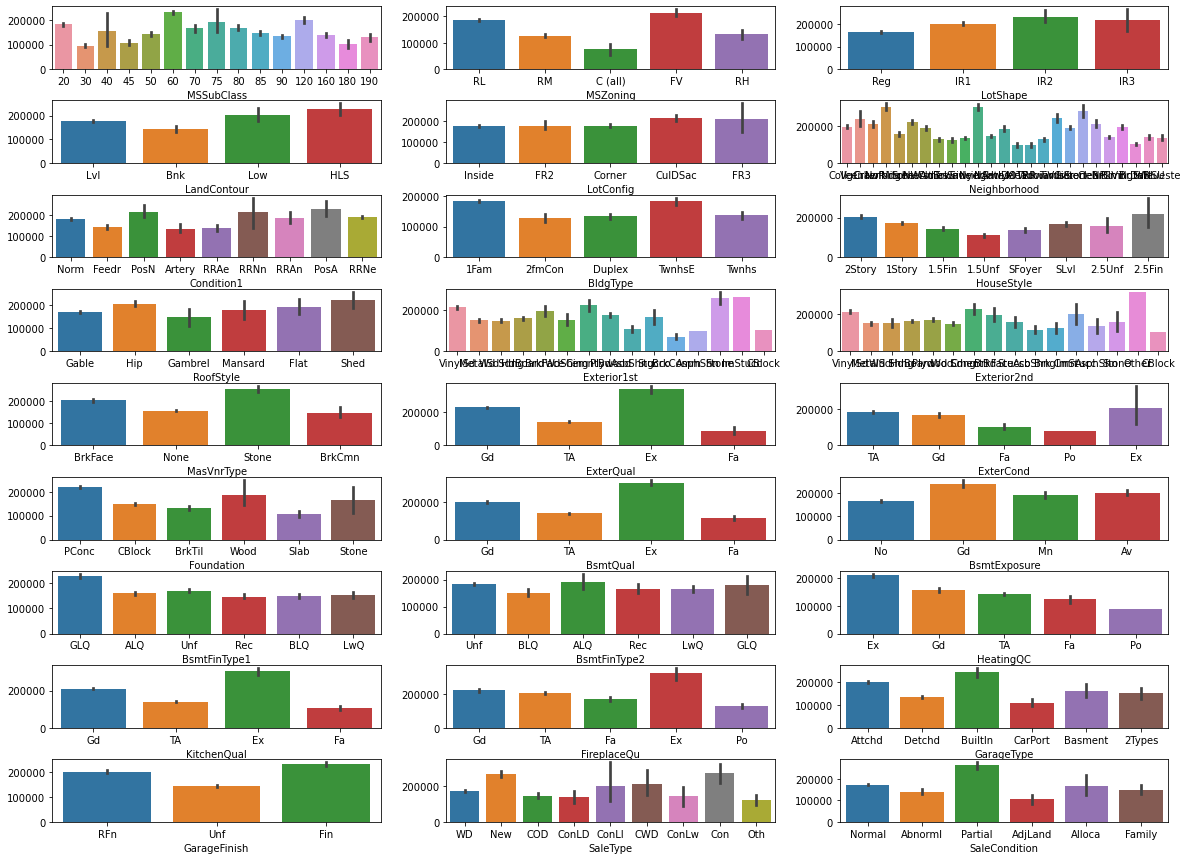

In [886]:
#Check Variation with target variable

tickers = cat_cols
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Feature v/s SalePrice", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(9, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.barplot(data=data,x=ticker,y="SalePrice")
    ax.set_ylabel("")


plt.show()

Categorical features seem to show a relation with the sale price

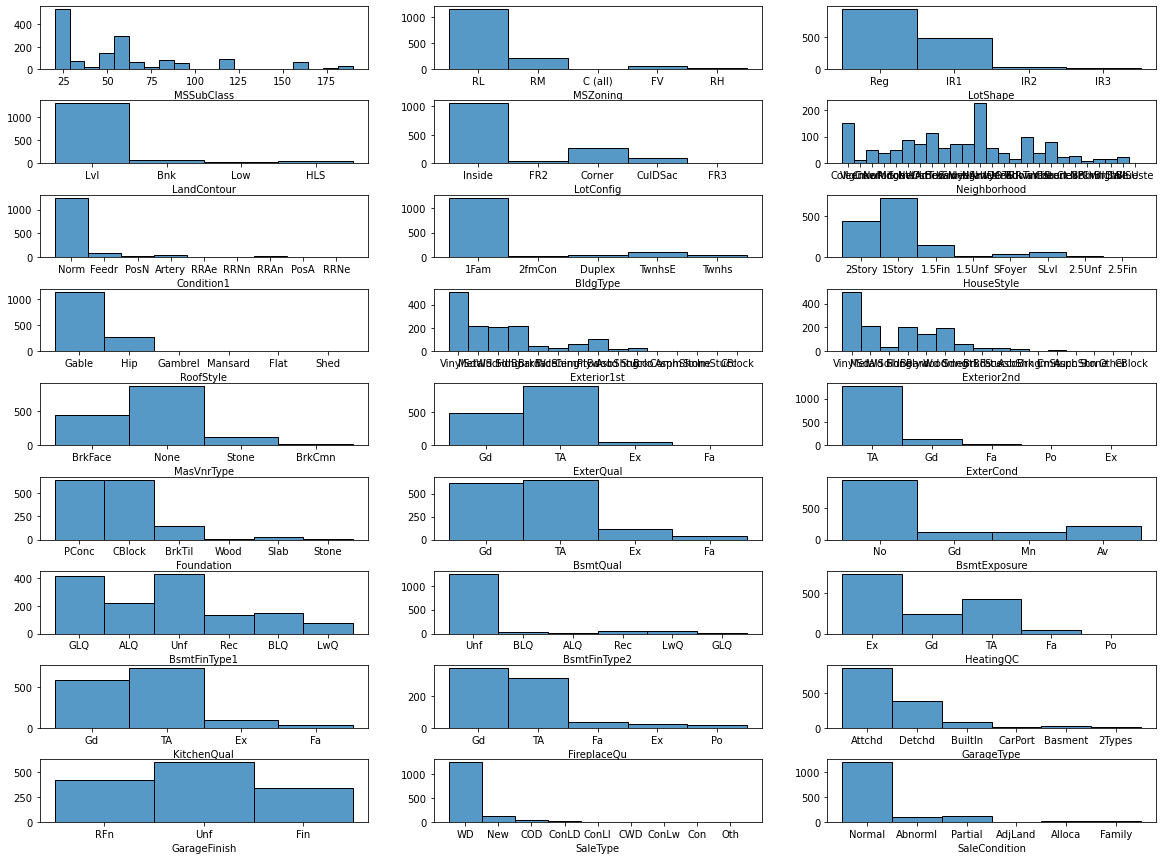

In [887]:
#Check Distribution of data

tickers = cat_cols
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Feature v/s SalePrice", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for n, ticker in enumerate(tickers):
    # add a new subplot iteratively
    ax = plt.subplot(9, 3, n + 1)

    # filter df and plot ticker on the new subplot axis
    sns.histplot(data[ticker])
    ax.set_ylabel("")


plt.show()

Features which show a similar SalePrice or low variation in sale price and have category imbalance amongst all categories can be removed

In [888]:
#Removing features based on data imbalance and low variation of SalePrice
low_var_cat=["Condition1","BsmtFinType1","LotConfig"]
data.drop(columns=low_var_cat,inplace=True)
cat_cols=list(set(cat_cols)-set(low_var_cat))

In [889]:
#EDA - Identifying Important variables based on data dictionary and distribution
top_cat=["MSZoning","GarageFinish","KitchenQual","ExterQual","BsmtQual"]

In [894]:
#Creation of Dummies for categorical variables
data=pd.get_dummies(data,drop_first=True)
print(data.shape)

(1451, 178)


In [899]:
#X & Y data
cols=list(data.columns)
y_col="SalePrice"
cols.remove(y_col)
X=data[cols]
y=data[y_col]

In [900]:
#Test-Train Split - 70-30% split
X_cols=list(data.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [901]:
#RFE used for feature selection
from statistics import LinearRegression


# estimator = LinearRegression()
# >>> selector = RFE(estimator, n_features_to_select=5, step=1)
# >>> selector = selector.fit(X, y)

(1015, 177)
